In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.cuda as tc
from torch.autograd import Variable
import torch.nn.functional as F

In [4]:
dt = pd.read_pickle('/Users/taraapple/Desktop/cifar-100-python/train')
df = pd.DataFrame.from_dict(dt, orient='index')
df = df.T
df.head()

,filenames,batch_label,fine_labels,coarse_labels,data
0,bos_taurus_s_000507.png,t,19,11,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
1,stegosaurus_s_000125.png,r,29,15,"[255, 253, 253, 253, 253, 253, 253, 253, 253, ..."
2,mcintosh_s_000643.png,a,0,4,"[250, 248, 247, 248, 249, 249, 248, 248, 247, ..."
3,altar_boy_s_001435.png,i,11,14,"[124, 131, 135, 138, 140, 144, 148, 152, 156, ..."
4,cichlid_s_000031.png,n,1,1,"[43, 32, 87, 127, 55, 48, 51, 87, 121, 113, 13..."


In [5]:
labels = list(pd.read_pickle('/Users/taraapple/Desktop/cifar-100-python/meta')['fine_label_names'])

In [6]:
# dictionaries with labels to idx and viceversa
labels_idx = {v:k for (k,v) in enumerate(labels)}
idx_labels = {k:v for (k,v) in enumerate(labels)}

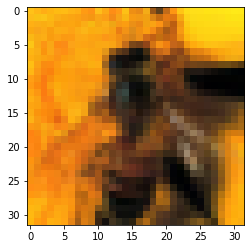

In [7]:
# display a bee image
img = np.array(df[df['fine_labels'] == labels_idx['bee']].iloc[10]['data']).reshape(3,32,32)
plt.imshow(img.transpose(1,2,0).astype("uint8"), interpolation='nearest')

In [8]:
data_values = df[df['fine_labels'].isin([labels_idx['bee'], labels_idx['butterfly']])]['data'].values
label_values = df[df['fine_labels'].isin([labels_idx['bee'], labels_idx['butterfly']])]['fine_labels'].values

In [9]:
features = np.array(np.stack(data_values, axis=0)).reshape(len(data_values), 3, 32, 32).astype('float32')
labels = np.array(label_values).astype('float32')

In [10]:
# normalize
features = features / 255.0

features = torch.from_numpy(features)
labels = torch.from_numpy(labels)

In [11]:
# create one hot enconding
labels[labels == labels_idx['bee']] = 0
labels[labels == labels_idx['butterfly']] = 1
labels = torch.eye(2)[labels.type(torch.LongTensor)]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [13]:
torch.manual_seed(999)
model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.Dropout(0.2),
            nn.MaxPool2d(3),
            nn.Flatten(),
            nn.Linear(1600, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 2),
            nn.LogSoftmax(dim=1))

In [14]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
kf = KFold(n_splits=3)

In [16]:
cnt = 1
losses = []
losses_test = []

for x_idx in kf.split(X_train):
    for e in range(501):
        for idx in x_idx:
            optimizer.zero_grad()
            out = model(X_train[idx])
            loss = criterion(out, torch.argmax(torch.Tensor(y_train[idx]).type(torch.torch.LongTensor), dim=1))
            loss.backward()
            optimizer.step()
        if(e % 100 == 0):
            pred_test = model(X_test)
            loss_test = criterion(pred_test, torch.argmax(torch.Tensor(y_test).type(torch.torch.LongTensor), dim=1))
            
            losses.append(loss)
            losses_test.append(loss_test)
            
            print('Split:%3d, Epoch:%4d, Loss:%.3f, Loss-test:%.3f' % (cnt, e, loss.item(), loss_test.item()))
    cnt += 1

Split:  1, Epoch:   0, Loss:0.694, Loss-test:0.694
Split:  1, Epoch: 100, Loss:0.690, Loss-test:0.692
Split:  1, Epoch: 200, Loss:0.687, Loss-test:0.688
Split:  1, Epoch: 300, Loss:0.683, Loss-test:0.683
Split:  1, Epoch: 400, Loss:0.675, Loss-test:0.674
Split:  1, Epoch: 500, Loss:0.661, Loss-test:0.658
Split:  2, Epoch:   0, Loss:0.671, Loss-test:0.657
Split:  2, Epoch: 100, Loss:0.653, Loss-test:0.631
Split:  2, Epoch: 200, Loss:0.638, Loss-test:0.603
Split:  2, Epoch: 300, Loss:0.625, Loss-test:0.580
Split:  2, Epoch: 400, Loss:0.613, Loss-test:0.569
Split:  2, Epoch: 500, Loss:0.602, Loss-test:0.561
Split:  3, Epoch:   0, Loss:0.578, Loss-test:0.561
Split:  3, Epoch: 100, Loss:0.559, Loss-test:0.555
Split:  3, Epoch: 200, Loss:0.541, Loss-test:0.554
Split:  3, Epoch: 300, Loss:0.521, Loss-test:0.555
Split:  3, Epoch: 400, Loss:0.497, Loss-test:0.556
Split:  3, Epoch: 500, Loss:0.462, Loss-test:0.558


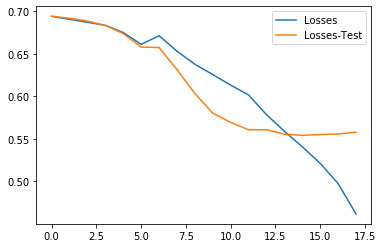

In [17]:
fig, ax = plt.subplots()
ax.plot(losses, label='Losses')
ax.plot(losses_test, label='Losses-Test')
leg = ax.legend()